# 02 - Training Skin Disease Classifier

Fine-tuning di ResNet50 per la classificazione di patologie cutanee nei cani.

## Dataset
- **Dog's Skin Diseases** (Kaggle): 4,315 immagini, 6 classi
  - Healthy
  - Dermatitis
  - Fungal_infections
  - Hypersensitivity
  - Demodicosis
  - Ringworm

## Output
- `P(disease)` ∈ [0, 1] - probabilità di patologia cutanea

In [1]:
# Installazione dipendenze
%pip install torch torchvision timm albumentations matplotlib seaborn pandas scikit-learn tqdm -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from PIL import Image
import cv2

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

/Users/vittoriodalfonso/Desktop/FIA/ResQPet/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]
PyTorch: 2.9.1
CUDA available: False
MPS available: True


In [3]:
# Device configuration
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f"Using device: {DEVICE}")

Using device: mps


In [ ]:
# Configurazione paths - RELATIVI per portabilità
import sys
sys.path.insert(0, str(Path.cwd()))
try:
    from notebook_utils import get_paths, get_device, print_paths
    paths = get_paths()
    print_paths(paths)
except ImportError:
    print("notebook_utils.py non trovato, usando fallback...")
    NOTEBOOK_DIR = Path.cwd()
    if NOTEBOOK_DIR.name == "notebooks":
        PROJECT_DIR = NOTEBOOK_DIR.parent.parent
    elif NOTEBOOK_DIR.name == "training":
        PROJECT_DIR = NOTEBOOK_DIR.parent
    else:
        PROJECT_DIR = NOTEBOOK_DIR
        while PROJECT_DIR.name != "ResQPet" and PROJECT_DIR.parent != PROJECT_DIR:
            PROJECT_DIR = PROJECT_DIR.parent
    BASE_DIR = PROJECT_DIR.parent
    paths = {
        'project_dir': PROJECT_DIR,
        'base_dir': BASE_DIR,
        'weights_dir': PROJECT_DIR / "backend" / "weights",
        'skin_dataset': BASE_DIR / "Dog's skin diseases",
        'notebooks_dir': PROJECT_DIR / "training" / "notebooks",
    }
    paths['weights_dir'].mkdir(parents=True, exist_ok=True)

# Assegna variabili per retrocompatibilità
BASE_DIR = paths['base_dir']
DATASET_DIR = paths['skin_dataset']
OUTPUT_DIR = paths['weights_dir']

print(f"\nDataset: {DATASET_DIR}")
print(f"Output: {OUTPUT_DIR}")
print(f"Dataset exists: {DATASET_DIR.exists()}")

## 1. Esplorazione Dataset

In [5]:
# Esplora struttura dataset
def explore_dataset(dataset_dir):
    stats = {}
    
    for split in ['train', 'valid', 'test']:
        split_dir = dataset_dir / split
        if not split_dir.exists():
            continue
            
        stats[split] = {}
        
        for class_dir in split_dir.iterdir():
            if class_dir.is_dir():
                images = list(class_dir.glob('*.*'))
                stats[split][class_dir.name] = len(images)
    
    return stats

dataset_stats = explore_dataset(DATASET_DIR)

print("Dataset Statistics:")
for split, classes in dataset_stats.items():
    print(f"\n{split.upper()}:")
    total = 0
    for cls, count in classes.items():
        print(f"  {cls}: {count}")
        total += count
    print(f"  TOTAL: {total}")

Dataset Statistics:

TRAIN:
  Healthy: 492
  Fungal_infections: 375
  ringworm: 791
  demodicosis: 588
  Hypersensitivity: 230
  Dermatitis: 546
  TOTAL: 3022

VALID:
  Healthy: 139
  Fungal_infections: 97
  ringworm: 212
  demodicosis: 174
  Hypersensitivity: 63
  Dermatitis: 175
  TOTAL: 860

TEST:
  Healthy: 69
  Fungal_infections: 54
  ringworm: 115
  demodicosis: 100
  Hypersensitivity: 29
  Dermatitis: 66
  TOTAL: 433


In [6]:
# Definisci classi e mapping
CLASS_NAMES = sorted(dataset_stats.get('train', {}).keys())
NUM_CLASSES = len(CLASS_NAMES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print(f"Classi: {CLASS_NAMES}")
print(f"Numero classi: {NUM_CLASSES}")

# Disease severity (per calcolo P(disease))
DISEASE_WEIGHTS = {
    'Healthy': 0.0,
    'Dermatitis': 0.6,
    'Fungal_infections': 0.7,
    'Hypersensitivity': 0.4,
    'demodicosis': 0.8,
    'ringworm': 0.75
}

print(f"\nDisease weights: {DISEASE_WEIGHTS}")

Classi: ['Dermatitis', 'Fungal_infections', 'Healthy', 'Hypersensitivity', 'demodicosis', 'ringworm']
Numero classi: 6

Disease weights: {'Healthy': 0.0, 'Dermatitis': 0.6, 'Fungal_infections': 0.7, 'Hypersensitivity': 0.4, 'demodicosis': 0.8, 'ringworm': 0.75}


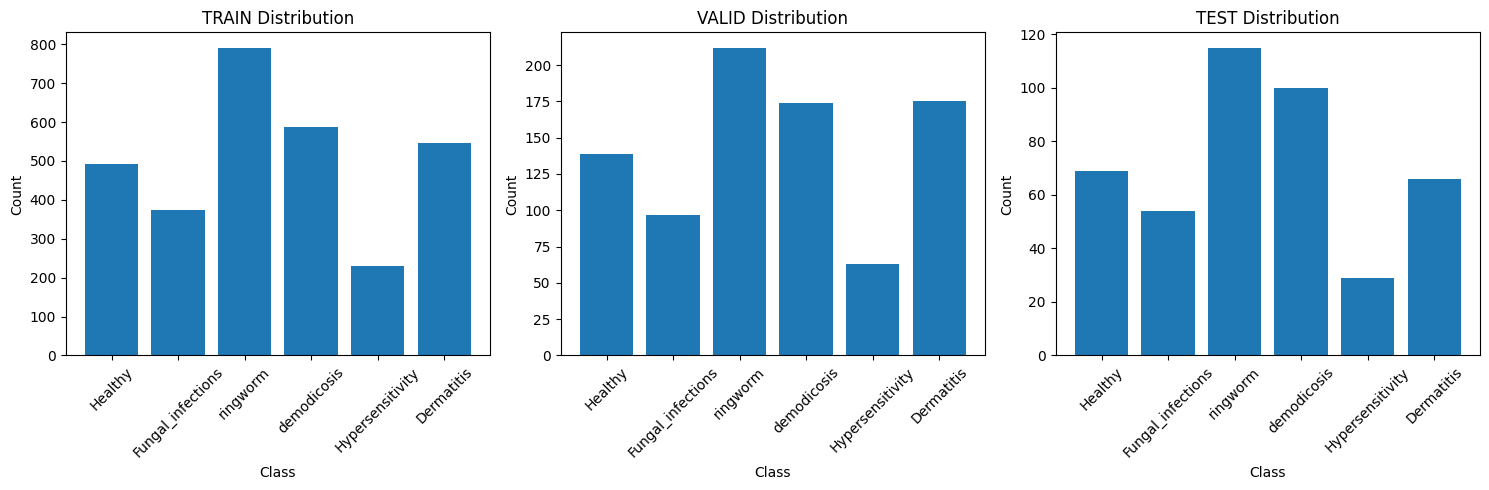

In [7]:
# Visualizza distribuzione classi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (split, classes) in enumerate(dataset_stats.items()):
    ax = axes[idx]
    ax.bar(classes.keys(), classes.values())
    ax.set_title(f'{split.upper()} Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR.parent.parent / 'training' / 'notebooks' / 'skin_class_distribution.png', dpi=150)
plt.show()

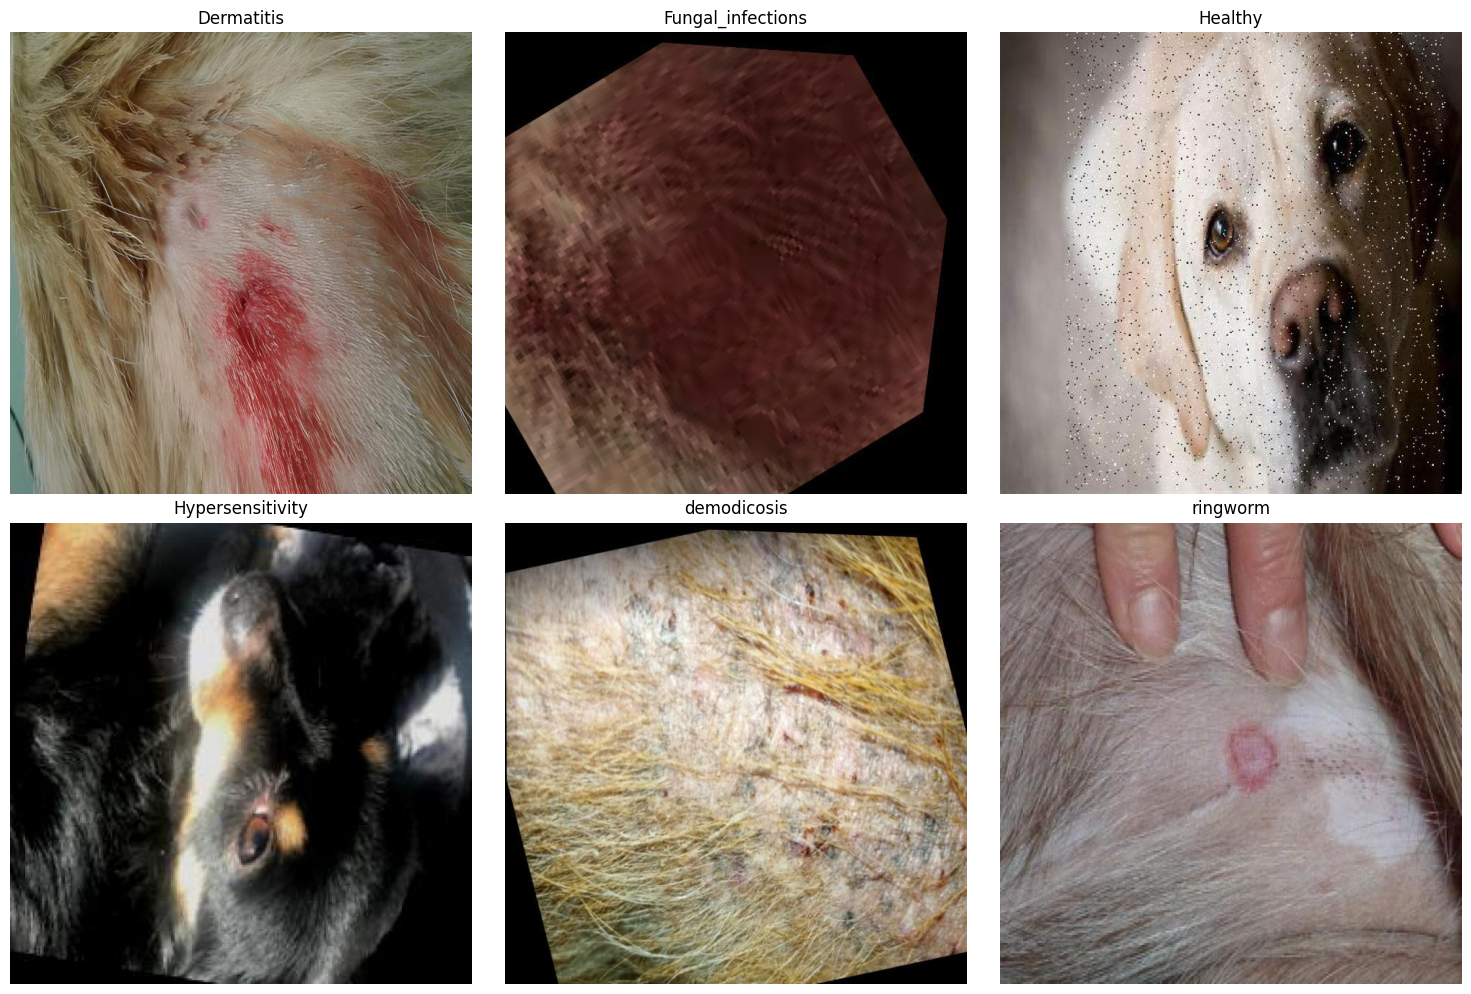

In [8]:
# Visualizza esempi per classe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES[:6]):
    class_dir = DATASET_DIR / 'train' / class_name
    if class_dir.exists():
        images = list(class_dir.glob('*.*'))[:1]
        if images:
            img = cv2.imread(str(images[0]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR.parent.parent / 'training' / 'notebooks' / 'skin_samples.png', dpi=150)
plt.show()

## 2. Dataset e DataLoader

In [9]:
class SkinDiseaseDataset(Dataset):
    """Dataset per classificazione patologie cutanee"""
    
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = Path(root_dir) / split
        self.transform = transform
        self.samples = []
        
        # Carica tutti i campioni
        for class_dir in self.root_dir.iterdir():
            if class_dir.is_dir() and class_dir.name in CLASS_TO_IDX:
                class_idx = CLASS_TO_IDX[class_dir.name]
                for img_path in class_dir.glob('*.*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(img_path), class_idx))
        
        print(f"Loaded {len(self.samples)} samples from {split}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Carica immagine
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [10]:
# Data transforms
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms definiti")

Transforms definiti


In [ ]:
# Crea dataset
train_dataset = SkinDiseaseDataset(DATASET_DIR, split='train', transform=train_transform)
val_dataset = SkinDiseaseDataset(DATASET_DIR, split='valid', transform=val_transform)
test_dataset = SkinDiseaseDataset(DATASET_DIR, split='test', transform=val_transform)

# DataLoaders
# NOTA: num_workers=0 su macOS per evitare problemi di multiprocessing con classi definite nel notebook
BATCH_SIZE = 32
NUM_WORKERS = 0  # Impostare a 4 se si esegue come script Python separato

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Num workers: {NUM_WORKERS} (impostare a 4 per script Python separato)")

## 3. Modello ResNet50

In [12]:
# Crea modello con timm
def create_model(num_classes, pretrained=True):
    """Crea ResNet50 con classification head custom"""
    model = timm.create_model(
        'resnet50',
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

model = create_model(NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

print(f"Model created: ResNet50")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created: ResNet50
Parameters: 23,520,326
Trainable: 23,520,326


## 4. Training

In [13]:
# Training configuration
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 10

# Class weights per dataset sbilanciato
train_counts = [sum(1 for s in train_dataset.samples if s[1] == i) for i in range(NUM_CLASSES)]
class_weights = torch.FloatTensor([max(train_counts) / c for c in train_counts]).to(DEVICE)
print(f"Class weights: {class_weights}")

# Loss e optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Class weights: tensor([1.4487, 2.1093, 1.6077, 3.4391, 1.3452, 1.0000], device='mps:0')


In [14]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return total_loss / len(loader), accuracy, f1, all_preds, all_labels

In [15]:
# Training loop
print("="*50)
print("INIZIO TRAINING SKIN CLASSIFIER")
print("="*50)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_f1 = 0
patience_counter = 0
best_model_path = OUTPUT_DIR / 'skin_classifier_best.pt'

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, DEVICE)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Log
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'class_names': CLASS_NAMES,
            'num_classes': NUM_CLASSES
        }, best_model_path)
        print(f"  ✓ Best model saved (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\n" + "="*50)
print("TRAINING COMPLETATO!")
print("="*50)

INIZIO TRAINING SKIN CLASSIFIER
Timestamp: 2025-11-30 12:42:04


Epoch 1/50


Training:   0%|                                                                                                                     | 0/95 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=112, pipe_handle=142)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SkinDiseaseDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

## 5. Valutazione Finale

In [ ]:
# Carica best model
# NOTA: weights_only=False necessario per PyTorch 2.6+
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Val F1: {checkpoint['val_f1']:.4f}")

In [ ]:
# Test finale
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, DEVICE
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(OUTPUT_DIR.parent.parent / 'training' / 'notebooks' / 'skin_confusion_matrix.png', dpi=150)
plt.show()

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_title('Accuracy')
axes[1].legend()

# F1
axes[2].plot(history['val_f1'], label='Val F1')
axes[2].set_title('Validation F1 Score')
axes[2].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR.parent.parent / 'training' / 'notebooks' / 'skin_training_curves.png', dpi=150)
plt.show()

## 6. Export Modello

In [ ]:
# Salva modello finale
final_model_path = OUTPUT_DIR / 'skin_classifier.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': CLASS_NAMES,
    'num_classes': NUM_CLASSES,
    'disease_weights': DISEASE_WEIGHTS,
    'test_accuracy': test_acc,
    'test_f1': test_f1
}, final_model_path)

print(f"Modello salvato in: {final_model_path}")
print(f"Dimensione: {final_model_path.stat().st_size / 1024 / 1024:.2f} MB")

In [ ]:
# Test del modello esportato
print("\nTest modello esportato...")

# Carica modello (weights_only=False per PyTorch 2.6+)
loaded_checkpoint = torch.load(final_model_path, weights_only=False)
test_model = create_model(loaded_checkpoint['num_classes'], pretrained=False)
test_model.load_state_dict(loaded_checkpoint['model_state_dict'])
test_model.eval()

# Test su un'immagine
test_img_path = list((DATASET_DIR / 'test' / CLASS_NAMES[0]).glob('*.*'))[0]
test_img = Image.open(test_img_path).convert('RGB')
test_tensor = val_transform(test_img).unsqueeze(0)

with torch.no_grad():
    output = test_model(test_tensor)
    probs = torch.softmax(output, dim=1)[0]
    pred_idx = probs.argmax().item()
    pred_class = CLASS_NAMES[pred_idx]
    pred_conf = probs[pred_idx].item()

print(f"\nTest image: {test_img_path.name}")
print(f"Prediction: {pred_class} ({pred_conf:.2%})")
print(f"\nProbabilità per classe:")
for i, cls in enumerate(CLASS_NAMES):
    print(f"  {cls}: {probs[i].item():.2%}")

In [ ]:
# Riepilogo finale
print("\n" + "="*50)
print("RIEPILOGO TRAINING SKIN CLASSIFIER")
print("="*50)
print(f"\nDataset: {DATASET_DIR}")
print(f"  - Classi: {NUM_CLASSES}")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Test samples: {len(test_dataset)}")
print(f"\nTraining:")
print(f"  - Epochs: {len(history['train_loss'])}")
print(f"  - Best epoch: {checkpoint['epoch']+1}")
print(f"\nRisultati Test:")
print(f"  - Accuracy: {test_acc:.4f}")
print(f"  - F1 Score: {test_f1:.4f}")
print(f"\nModello salvato: {final_model_path}")
print("\nProssimo step: 03_pose_training.ipynb")